# Simulating semi-supervised learning on imbalanced data

In [55]:
# Create 2-D gaussians example dataset with class imbalance
import matplotlib.pyplot as plt
import numpy as np


# Define 2-D Gaussians
mean_A = [0.5, 0.5]
cov_A = [[1,0], [0,2]]
mean_B = [-2.5, 0.5]
cov_B = [[2,0], [0,1]]



In [3]:
def draw_data(NUM_A, NUM_B):
    # Draw dataset from pre-defined Gaussians
    x_A, y_A = np.random.multivariate_normal(mean_A, cov_A, NUM_A).T
    x_B, y_B = np.random.multivariate_normal(mean_B, cov_B, NUM_B).T
    data = np.vstack((np.hstack((x_A[:,np.newaxis], y_A[:,np.newaxis])),
              np.hstack((x_B[:,np.newaxis], y_B[:,np.newaxis]))))
    label = np.concatenate((-np.ones(NUM_A), np.ones(NUM_B)))
    return data, label, (x_A, y_A, x_B, y_B)

### Generate datasets

In [4]:
# Generate labeled training dataset
NUM_A = 1000
NUM_B = 50
feat_train, label_train, (x_A, y_A, x_B, y_B) = draw_data(NUM_A, NUM_B)

# Generate unlabeled data (10x more than labeled training)
NUM_A = 10000
NUM_B = 500
feat_u, _, (xu_A, yu_A, xu_B, yu_B) = draw_data(NUM_A, NUM_B)

# Generate test data (same size as original data)
NUM_A = 1000
NUM_B = 50
feat_t, label_t, (xt_A, yt_A, xt_B, yt_B) = draw_data(NUM_A, NUM_B)


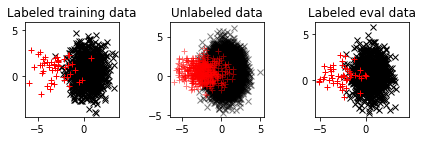

In [6]:
# Plot the data

plt.subplot(1, 3, 1)
plt.plot(x_A, y_A, 'kx')
plt.plot(x_B, y_B, 'r+')
plt.axis('square')
plt.title('Labeled training data')
plt.tight_layout()

plt.subplot(1, 3, 2)
plt.plot(xu_A, yu_A, 'kx', alpha=0.5)
plt.plot(xu_B, yu_B, 'r+', alpha=0.5)
plt.axis('square')
plt.title('Unlabeled data')
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.plot(xt_A, yt_A, 'kx')
plt.plot(xt_B, yt_B, 'r+')
plt.axis('square')
plt.title('Labeled eval data')
plt.tight_layout()

plt.show()

### Supervised model

In [7]:
# Train a supervised model
from sklearn.svm import LinearSVC
model = LinearSVC(random_state=0, loss='hinge', verbose=2)
model.fit(feat_train, label_train) # Fit model to labeled training data


[LibLinear]

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=0, tol=0.0001, verbose=2)

### Semi-supervised model

In [8]:
# Semi-supervised learning: 

# Predict labels for unlabeled data
preds_u = model.predict(feat_u)  # y_hat
print preds_u.shape
print np.unique(preds_u)

# Training: original Data + predicted Data
model_semi = LinearSVC(random_state=0, loss='hinge', verbose=1)
X_new = np.vstack((feat_train, feat_u))
y_new = np.concatenate((label_train, preds_u))
model_semi.fit(X_new, y_new)


(10500,)
[-1.]
[LibLinear]

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=0, tol=0.0001, verbose=1)

### Compare performance (single run)

In [9]:
# Evaluate model scores
y_hat = model.decision_function(feat_t)
y_hat_semi = model_semi.decision_function(feat_t)

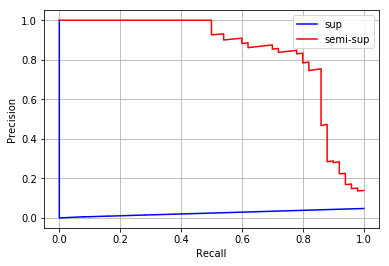

In [10]:
from sklearn.metrics import precision_recall_curve

prec, rec, _ = precision_recall_curve(label_t, y_hat)
plt.plot(rec, prec, color='b', label='sup')
prec, rec, _ = precision_recall_curve(label_t, y_hat_semi)
plt.plot(rec, prec, color='r', label='semi-sup')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid()
plt.show()

## Averaged runs of semi-supervised training

In [11]:
from sklearn.metrics import average_precision_score

NUM_TRIAL = 1000

ap_sup = np.zeros(NUM_TRIAL)
ap_semi = np.zeros(NUM_TRIAL)

for i in range(NUM_TRIAL):
    # Generate labeled training dataset
    NUM_A = 1000
    NUM_B = 50
    feat_train, label_train, (x_A, y_A, x_B, y_B) = draw_data(NUM_A, NUM_B)

    # Generate unlabeled data (10x more than labeled training)
    NUM_A = 10000
    NUM_B = 500
    feat_u, _, (xu_A, yu_A, xu_B, yu_B) = draw_data(NUM_A, NUM_B)

    # Generate test data (same size as original data)
    NUM_A = 1000
    NUM_B = 50
    feat_t, label_t, (xt_A, yt_A, xt_B, yt_B) = draw_data(NUM_A, NUM_B)
    
    # Supervised model
    model = LinearSVC(random_state=0, loss='hinge')
    model.fit(feat_train, label_train) # Fit model to labeled training data
    
    # Predict labels for unlabeled data
    preds_u = model.predict(feat_u)  # y_hat

    # Semi-supervised model: original Data + predicted Data
    model_semi = LinearSVC(random_state=0, loss='hinge')
    X_new = np.vstack((feat_train, feat_u))
    y_new = np.concatenate((label_train, preds_u))
    model_semi.fit(X_new, y_new)
    
    # Evaluate model scores
    y_hat = model.decision_function(feat_t)
    y_hat_semi = model_semi.decision_function(feat_t)
    
    ap_sup[i] = average_precision_score(label_t, y_hat)
    ap_semi[i] = average_precision_score(label_t, y_hat_semi)
    

In [12]:
print 'AP (sup): %f +/- %f' % (np.mean(ap_sup), np.std(ap_sup))
print 'AP (semi): %f +/- %f' % (np.mean(ap_semi), np.std(ap_semi))

AP (sup): 0.789462 +/- 0.048653
AP (semi): 0.789776 +/- 0.048579


In [13]:
noise_vec = np.random.uniform(0, 1, label_train.shape)
mask= 2* (noise_vec < 0.8) - 1

print np.sum(mask==1)
print np.sum(mask==-1)

824
226


## Semi-supervised with noisy labels

In [63]:
from sklearn.metrics import average_precision_score

NUM_TRIAL = 1000
LABEL_NOISE = 0.1  

ap_sup = np.zeros(NUM_TRIAL)
ap_semi = np.zeros(NUM_TRIAL)

for i in range(NUM_TRIAL):
    print i,
    
    # Generate labeled training dataset
    NUM_A = 1000
    NUM_B = 100
    feat_train, label_train, (x_A, y_A, x_B, y_B) = draw_data(NUM_A, NUM_B)
    
    # add noise to labels - flip +1 to -1 (and vice versa)
    noise_vec = np.random.uniform(0, 1, label_train.shape)
    mask = 2* (noise_vec < (1-LABEL_NOISE) ) - 1
    label_train = label_train * mask
    

    # Generate unlabeled data (10x more than labeled training)
    NUM_A = 10000
    NUM_B = 500
    feat_u, _, (xu_A, yu_A, xu_B, yu_B) = draw_data(NUM_A, NUM_B)

    # Generate test data (same size as original data)
    NUM_A = 1000
    NUM_B = 100
    feat_t, label_t, (xt_A, yt_A, xt_B, yt_B) = draw_data(NUM_A, NUM_B)
    
    # Supervised model
    model = LinearSVC(random_state=0, loss='hinge')
    model.fit(feat_train, label_train) # Fit model to labeled training data
    
    # Predict labels for unlabeled data
    preds_u = model.predict(feat_u)  # y_hat

    # Semi-supervised model: original Data + predicted Data
    model_semi = LinearSVC(random_state=0, loss='hinge')
    X_new = np.vstack((feat_train, feat_u))
    y_new = np.concatenate((label_train, preds_u))
    model_semi.fit(X_new, y_new)
    
    # Evaluate model scores
    y_hat = model.decision_function(feat_t)
    y_hat_semi = model_semi.decision_function(feat_t)
    
    ap_sup[i] = average_precision_score(label_t, y_hat)
    ap_semi[i] = average_precision_score(label_t, y_hat_semi)
    


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [64]:
print 'AP (sup-noisy): %f +/- %f' % (np.mean(ap_sup), np.std(ap_sup))
print 'AP (semi-noisy): %f +/- %f' % (np.mean(ap_semi), np.std(ap_semi))

AP (sup-noisy): 0.711493 +/- 0.242256
AP (semi-noisy): 0.493944 +/- 0.347945
